In [1]:
# python packages used to analyze this data

from ananke.graphs import ADMG
from ananke.identification import OneLineID
from ananke.estimation import CausalEffect
import numpy as np
import pandas as pd

# Premise

As all of you are well aware, a prominent member of the Dota 2 community, SirActionSlacks recently posted [this video](https://www.youtube.com/watch?v=gOqCyGd7lRs) declaring his long-standing hatred for Windranger and making some serious accusations about the viability of the hero. 1 minute and 7 seconds into the video SirActionSlacks evokes what is essentially the Bat signal for causal inference researchers. He quite correctly states that **correlation is not causation** and muses, well, can we really tell if Windranger **causes** us to lose in our pubs, and pros to lose at TI. He then proceeds to provide anecdotal evidence that Windranger truly is a cause for losses.

Now, I wondered for a while about how I could gather the correct kind of data given that most games are spread over several patches and performing a sound causal analysis of ever-shifting distributions can be quite tricky. To my delight, soon after SirActionSlacks' video, another prominent member of the community, Wagamama, promised to play 100 games of Windranger first pick (unless banned). His games over this period turned out to be just what I was looking for!

# The Question

To formalize the causal question: one way to get at what SirActionSlacks is asking is -- what is the probability of winning had I forced (intervened) on everyone to pick Windranger vs. had I forced everyone to pick some other hero. Or if you're familiar with do-calculus what is the **Average Causal Effect (ACE)** of Windranger on winning the game:

$ACE = E[Win\mid do(Windranger=1)] - E[Win\mid do(Windranger=0)]$

When the outcome of interest is a binary variable, as is the case in the present analysis (did you win or not), the causal effect is often reported as an **odds ratio**.

$
\text{Causal odds} = \frac{p(Win=1\mid do(Windranger=1)/p(Win=0\mid do(Windranger=1)}{p(Win=1\mid do(Windranger=0)/p(Win=0\mid do(Windranger=0)}
$

Thus, in this analysis, I consider Windranger to be the **"treatment"** of interest and winning to be the **"outcome"** (a lot of causal theory comes from epidemiology and economics, hence the terms.)

# The Data

I compiled the data from the Dotabuff for Wagamama's smurf [Zátopek](https://www.dotabuff.com/players/123048453) since he began this challenge (123 games total). For each game, I collected data on the following variables that I thought might be key in the analysis:
* **MatchID** - unique identifier for the match.
* **NotBanned** - was Windranger not banned (0 or 1).
* **Windranger** - Did Waga pick Windranger (0 or 1).
* **GPM** - Waga's gold per minute.
* **XPM** - Waga's experience per minute.
* **Blademail** - Did the enemy team buy one or more blademails (0 or 1).
* **GhostEblade** - Did the enemy team buy one or more ghost sceptres/eblades/have a hero capable of ethereal form (0 or 1).
* **HeroCounter** - Was there a counter to Waga's hero on the enemy team (0 or 1). Top 5 counters listed on Dotabuff at the time were considered. These were -- Tinker, Centaur, Shadow Demon, Ember Spirit, Mars for Windranger. If Waga played a different hero, the corresponding top 5 counters for the hero were used.
* **KillingItem** - Did enemies buy an item explicitly to kill Waga's hero (0 or 1). For Windranger I considered this to be items that grant true strike e.g. MKB, Divine Rapier, Bloodthorn as well as burst like Dagon + Veil. For a hero like Weaver, I considered this to be items like Orchid/Bloodthorn and Hex.
* **Damage** - Amount of damage output by Waga.
* **Win** - Did Waga win (0 or 1).
* **Notes** - Some notes I took while curating the data.

In [2]:
# read in data and drop some meta-data columns
data = pd.read_csv("waga_data.csv")
data = data.drop(columns=["Notes", "MatchID"])

# If Correlation Were Causation

So first, say we were to assume that correlation **is** causation. This can happen only if we are willing to believe that any factors that cause Waga to pick Windranger do not also affect his chances of winning the game. That is, Waga's tendency to pick Windranger is **perfectly randomized** and there are no unmeasured confounders. Since I primarily do causal inference with graphs, let's look at what the graph of a **randomized controlled trial** looks like where the "treatment" is whether Waga picks Windranger or not, and the outcome is if he wins or not.

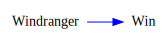

In [3]:
G = ADMG(vertices=["Windranger", "Win"], di_edges=[("Windranger", "Win")])
G.draw(direction="LR")

Now if I were willing to believe this is how Waga played his games, then correlation between picking Windranger and winning would, in fact, be causation. That's why we place a lot of importance in the findings of randomized controlled trials. More formally, for those of you familiar with do-calculus or potential outcomes calculus, in randomized controlled trials,

$p(Outcome\mid do(Treatment)) = p(Outcome \mid Treatment).$

So let's compute what the odds ratio is under this model of the world.

In [4]:
# Computing the odds ratio naively as if correlation IS causation

# Assuming p(Win | do(Windranger=0)) = p(Win | Windranger=0)
data_0 = data[data["Windranger"]==0]
p_Win0 = np.sum(data_0["Win"]==1)/len(data_0)

# Assuming p[Win | do(Windranger=1)] = p[Win | Windranger=1]
data_1 = data[data["Windranger"]==1]
p_Win1 = np.sum(data_1["Win"]==1)/len(data_1)
odds_ratio = (p_Win1/(1-p_Win1))/(p_Win0/(1-p_Win0))

# Odds ratio
print("Odds ratio assuming Waga's games were like a Randomized Controlled Trial =", odds_ratio)

Odds ratio assuming Waga's games were like a Randomized Controlled Trial = 1.2151162790697672


The interpretation of this number being ~1.2 is that, if we were to believe correlation is causation, then the odds of you winning if you force yourself to pick Windranger is about 1.2 times higher than if you force yourself to pick some other hero. That's quite a large effect, and directly goes against the claims made by SirActionSlacks in his video. However, we started with the understanding that the world is not so simple and unmeasured confounders makes any causal interpretation of the number computed above invalid. So what do we do, when we have unmeasured confounders? I'll discuss two possible options -- the use of **instrumental variables** to provide bounds on the effect, and the use of **front-door estimation** to provide a point-identified estimate of the effect.


# The Instrumental Variable Model

Now looking more closely at the data, we see that Waga does not always pick Windranger when it is not banned. As SirActionSlacks mentions in his video, we can never truly know the underlying psyche that caused Waga to not pick Windranger despite it not being banned. Further, this same underlying mental state may also cause Waga to win or lose his games. However, it is certainly the case that whether Windranger is banned or not is a strong predictor of whether Waga will pick the hero. Further, the ban status of the hero is not a direct cause of Waga losing or winning his games, it only affects the outcome through the actual picking of the hero. It also seems plausible to assume that whether or not people choose to ban Windranger does not share any common causes with the final outcome. Thus, the ban status of the hero is a perfect candidate for an **instrumental variable** for our causal analysis. Informally speaking, an instrumental variable satisfies three conditions.
* It is truly associated with or truly incentivizes treatment,
* It affects the outcome only via the treatment, and
* It does not share common causes with the outcome.

Let's look at the graph (the bidirected red edge corresponds to the unmeasured confounding through mental state etc. that we are not able to take into account).

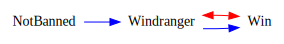

In [5]:
G = ADMG(vertices=["Windranger", "Win", "NotBanned"],
         di_edges=[("Windranger", "Win"), ("NotBanned", "Windranger")], bi_edges=[("Windranger", "Win")])
G.draw(direction="LR")

Now it turns out that having a candidate instrumental variable by itself is not enough to point identify the causal effect of a treatment on an outcome. There's a fourth condition that has many flavours, none of which I particularly wanted to use for this analysis (details of these conditions can be found in Chapter 16 of [this](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2020/02/ci_hernanrobins_21feb20.pdf) book). Instead, I will only assume that I have a valid instrument, and further, notice that **monotonicity** holds. This allows me to provide tighter **bounds** than usual on the **average causal effect**. Formally, monotonicity assumes that the following is true,

$p(Windranger=1 | NotBanned=1, UnmeasuredFactors) \geq p(Windranger=1 | NotBanned=0, UnmeasuredFactors).$

Why do I believe that this is true for this data? Well, the ban mechanic is such that when Windranger is banned, the hero can never be picked. Thus, $p(Windranger=1 | NotBanned=0, UnmeasuredFactors)=0!$ We can then obtain some relatively tight bounds on the average causal effect. I know it's a little clunky the way I use $NotBanned$ instead of $Banned$ and force you to think of double negatives but typically instruments are stated as ways of incentivizing people to take their treatment. So in this sense, not banning Windranger incentivizes Waga to pick the hero.

For more information on such bounds, [Palmer et al, 2011](https://journals.sagepub.com/doi/pdf/10.1177/1536867X1101100302) provides a nice overview and seminal works on the topic include [Balke & Pearl, 1997](https://www.tandfonline.com/doi/abs/10.1080/01621459.1997.10474074), [Manksi, 1990](https://ipcig.org/evaluation/outros_temas/Manski%20-%20Nonparametric%20Bounds.pdf), and [Robins, 1989](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/343/2013/03/nchsr.pdf).

In [6]:
# given notbanned=0
data_0 = data[data["NotBanned"]==0]
p00c0 = np.sum((data_0["Win"]==0) & (data_0["Windranger"]==0))/len(data_0)
p01c0 = np.sum((data_0["Win"]==0) & (data_0["Windranger"]==1))/len(data_0) # should be 0 because windranger cannot be picked when banned
p11c0 = np.sum((data_0["Win"]==1) & (data_0["Windranger"]==1))/len(data_0) # should also be 0 for same reasons

# given notbanned=1
data_1 = data[data["NotBanned"]==1]
p00c1 = np.sum((data_1["Win"]==0) & (data_1["Windranger"]==0))/len(data_1)
p01c1 = np.sum((data_1["Win"]==0) & (data_1["Windranger"]==1))/len(data_1)
p10c1 = np.sum((data_1["Win"]==1) & (data_1["Windranger"]==0))/len(data_1)

print(p00c0 - p00c1 - p01c1 - p10c1, "<= ACE <=", p00c0 + p01c0 + p11c0 - p01c1)

0.008324084350721399 <= ACE <= 0.06492785793562705


Because this bound is (just about) away from zero, what this means is that $p(Win=1 \mid (do(Windranger=1)) > p(Win \mid (do(Windranger=0)).$ So, the bounds tell us, that contrary to SirActionSlacks' video, you're ever so slightly better off forcing yourself (or rather Waga) to pick Windranger every game! Now, one may argue that bounds itself (even if relatively tight like this one) are not very satisfying. Point estimates are sometimes more appealing. So let's look at the front-door trick that can help get a point estimate of a causally interpretable odds ratio.

# Front-Door Estimates

The essence of front-door is this: you acknowledge the fact that there may be unmeasured confounding between your treatment and outcome but, what you can help yourself to is a factor that **strongly mediates** the effect of the treatment on the outcome. That is, there is no (unmeasured) confounding between the treatment and the mediator, nor the mediator and the outcome. SirActionSlacks in his video repeatedly mentions that the purchase of Blademails is essentially a death sentence to Windranger players. This is corroborated in a Tweet by Wagamama soon after he was done with his 100 games of Windranger in which he laments the purchase of many Blademails. So, I'm going to use the purchase of Blademails by the enemy heroes as a strong mediator for the possibility of winning or losing. Graphically,

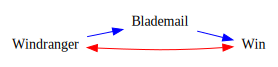

In [7]:
# front-door using blademail as mediator
vertices = ["Windranger", "Blademail", "Win"]
di_edges = [("Windranger", "Blademail"), ("Blademail", "Win")]
bi_edges = [("Windranger", "Win")]
G = ADMG(vertices, di_edges, bi_edges)
G.draw(direction="LR")

And then I use [Ananke](https://ananke.readthedocs.io/en/latest/index.html) to do the heavy lifting for me in computing the effect from my data under this model of the world. For more on the technical details on computing statistically efficient causal effects using semiparametric theory, see my recent paper on the topic [Bhattacharya, Nabi, & Shpitser, 2020](https://arxiv.org/pdf/2003.12659.pdf). I perform 100 bootstraps in order to obtain a $95\%$ confidence interval for the causal odds ratio.

In [8]:
# front-door using blademail as mediator
np.random.seed(322)
# check that the effect is indeed identified
print(OneLineID(graph=G, treatments=['Windranger'], outcomes=['Win']).id())
G.draw(direction="LR")
ace_obj = CausalEffect(graph=G, treatment='Windranger', outcome='Win')  # setting up the CausalEffect object
ace = ace_obj.compute_effect(data, "apipw", n_bootstraps=100, alpha=0.05)
odds, Ql, Qu = np.exp(ace)
print("Causal odds under front-door =", odds, "(", Ql, Qu, ")")

True

 Treatment is p-fixable and graph is mb-shielded. 

 Available estimators are:

1. Primal IPW (p-ipw)
2. Dual IPW (d-ipw)
3. APIPW (apipw)
4. Efficient APIPW (eff-apipw) 
 
Suggested estimator is Efficient APIPW 

Causal odds under front-door = 0.9890351561226444 ( 0.8721174397553569 1.0645698715798315 )


A (conservative) interpretation of the above number being ~1 (and the confidence interval covering 1) is that the odds of winning under an intervention where you (or Waga) are forced to pick Windranger every game is no higher or lower than if you are forced to pick another hero.

Finally, I tried an alternative model where the causal effect is still identified that also incorporates information about whether Waga's opponents purchased Ghost sceptres, Ethereal blades, or were otherwise capable of ethereal form (such as Necro and Pugna). My hope is that work like this inspires others to try other cool models and play around with the causal tools in Ananke and causal inference theory in order to see what they can come up with :)

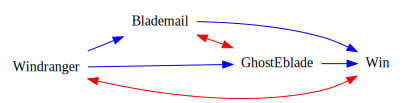

In [9]:
# front-door using blademail and ghost/eblade as mediator
vertices = ["Windranger", "Blademail", "Win", "GhostEblade"]
di_edges = [("Windranger", "Blademail"), ("Windranger", "GhostEblade"), ("Blademail", "Win"), ("GhostEblade", "Win")]
bi_edges = [("Windranger", "Win"), ("Blademail", "GhostEblade")]
G = ADMG(vertices, di_edges, bi_edges)
G.draw(direction="LR")

In [10]:
np.random.seed(322)
# once again check that the effect is still identified.
print(OneLineID(graph=G, treatments=['Windranger'], outcomes=['Win']).id())
G.draw(direction="LR")
ace_obj = CausalEffect(graph=G, treatment='Windranger', outcome='Win')  # setting up the CausalEffect object
ace = ace_obj.compute_effect(data, "apipw", n_bootstraps=100, alpha=0.05)
odds, Ql, Qu = np.exp(ace)
print("Causal odds under front-door =", odds, "(", Ql, Qu, ")")

True

 Treatment is p-fixable and graph is mb-shielded. 

 Available estimators are:

1. Primal IPW (p-ipw)
2. Dual IPW (d-ipw)
3. APIPW (apipw)
4. Efficient APIPW (eff-apipw) 
 
Suggested estimator is Efficient APIPW 

Causal odds under front-door = 1.0227511255434745 ( 0.8944720794627975 1.2367081141680751 )


The addition of this variable does not change the analysis much, which is good since it means that the purchase of blademail is already quite a strong mediator of the effect.


# Discussion & Conclusions

So what can we conclude from the above analyses? Using principled strategies for causal inference such as instrumental variable analysis and front-door analysis can yield interesting insights into the universe of Dota 2. The fact that the instrumental variable and front-door methods both point to the causal effect of picking Windranger on winning to be (roughly) null, I view this as a sign that Windranger is a well balanced hero (which is a testament to the attention to detail by the developers of the game). On average, if you force (intervene on) yourself to pick Windranger every game, you are no more likely to lose than you are to win. I conjecture, that if I were to run a similar analysis on a currently "broken" hero such as Ember Spirit or "high-risk" hero such as Meepo the findings would be quite different.

Of course 123 games is a small sample size, and I have only analyzed the games of a single (and highly skilled) player. These findings may not **transport** to other skill brackets and may also change given more data. But I am excited about the possibilities for more causal analysis of this kind in the world of Dota 2! The present analysis, however, unfortunately does not support SirActionSlacks' claim of Windranger being a terrible hero!

# Acknowledgements

Thank you to SirActionSlacks, this analysis would not have come to life had he not made such an entertaining and polarizing video. And also a huge thanks to Wagamama for undertaking the 100 games Windranger challenge that also made this analysis possible.